# Open cluster cataloging
##### In this notebook we study the discrepancies between various (open) cluster catalogues. We use the open cluster catalogue by Hunt & Reffert (2023) as reference cluster and we base our results under the assumptions that the catalogue concerned, achieved the most accurate and precise data for the open clusters in question.

First we start by creating a datahandler made to get tables from the catalogues in question. We crossmatch the literature with the crossmatch table by Hunt & Reffert (2023). We then see if any of those crossmatched clusters occur in the original literature data. The clusters in the literature can be in one of two states which yields respective data tables:
- Matched = The clusters from the literature is confirmed by the Hunt-catalogue
  - Out of $N$ literature clusters $C$ Hunt-clusters are confirmed which yields $C$ records in the literature-and Hunt-catalogue (I and II in the code)
- Not Matched = The clusters from the literature is not confirmed
  - Out of $N$ literature clusters $N-C$ literature clusters are refuted which yields $N-C$ records in the literature catalogue (III in the code) 



In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const


cantat = pd.read_csv('Data\\CantatGaudin\\cantatgaudinfile.csv')
hunt = pd.read_csv('Data\\Hunt\\huntfile.csv')
xmatch = pd.read_csv('Data\\Hunt\\xmatchfile.csv').dropna(subset='Sep')
khar = pd.read_csv('Data\\Kharchenko\\kharchenkofile.csv').query('Type != "g"')
dias = pd.read_csv('Data\\Dias\\diasfile.csv')
dias['Cluster'] = dias['Cluster'].str.replace(' ', '_').str.replace('-', '_')

In [156]:
def datahandler(df_lit, df=hunt, crossmatch=xmatch):

    if df_lit is cantat: # Define the source catalog and the column name of the cluster name, each table has different names for the cluster name column
        sourcecat = 'Cantat-Gaudin+20'
        NameCol = 'Cluster'
    elif df_lit is khar:
        sourcecat = 'Kharchenko+13'
        NameCol = 'Name'
    elif df_lit is dias:
        sourcecat = 'Dias+02'
        NameCol = 'Cluster'

    df = df.query('Type == "o"') #Only open clusters
    crossmatch = crossmatch.query('SourceCat == @sourcecat').drop_duplicates('ID')

    xm = pd.merge(crossmatch, df, on='ID', how='inner') #Crossmatched clusters
    allnames = xm.assign(synonym = xm['AllNames'].str.split(',')).explode('synonym').add_suffix('_h') #Create AllNames column with synonyms of the OCs
    
    df_matched = pd.merge(df_lit, allnames, left_on=NameCol, right_on='synonym_h', how='outer', indicator=True).drop_duplicates(NameCol) #Crossmatched clusters (matched with literature)
    
    matched = df_matched.query('_merge == "both"') #Matched clusters
    not_matched = df_matched.query('_merge == "left_only"') #Not matched clusters
    
    hunt_matched = matched.filter(regex='_h$').drop(columns=['synonym_h']) # Matched clusters in Hunt (I)
    # remove _h from the column names
    hunt_matched.columns = hunt_matched.columns.str.replace('_h', '')
    
    lit_matched = matched[df_lit.columns] # Matched clusters in literature (II)
    lit_not_matched = not_matched[df_lit.columns] # Not matched clusters in literature (III)
    
    return hunt_matched, lit_matched, lit_not_matched


In [157]:
cantat_matched, cantat_lit, cantat_not_matched = datahandler(cantat)
# khar_matched, khar_lit, khar_not_matched = datahandler(khar)
# dias_matched, dias_lit, dias_not_matched = datahandler(dias)

# print(f'Cantat matched: {cantat_matched.shape[0]}, Cantat not matched: {cantat_not_matched.shape[0]}, Cantat total: {cantat.shape[0]}')
# print(f'Kharchenko matched: {khar_matched.shape[0]}, Kharchenko not matched: {khar_not_matched.shape[0]}, Kharchenko total: {khar.shape[0]}')
# print(f'Dias matched: {dias_matched.shape[0]}, Dias not matched: {dias_not_matched.shape[0]}, Dias total: {dias.shape[0]}')
# print('These numbers are different from the numbers in the paper of Hunt & Reffert (2023), which is a result of the different crossmatch method used in this work.')


In [158]:
cantat_matched.to_csv('Data\\CantatGaudin\\cantat_matched.csv', index=False)
cantat_lit.to_csv('Data\\CantatGaudin\\cantat_lit.csv', index=False)
cantat_not_matched.to_csv('Data\\CantatGaudin\\cantat_not_matched.csv', index=False)

### Coordinate transformation
Here we write some coordinate transformation functions using astropy

In [159]:
def galto_galcen(data):
    x, y, z = data['X'].values, data['Y'].values, data['Z'].values
    coords = coord.SkyCoord(x=x*u.pc, y=y*u.pc, z=z*u.pc, frame='galactic').transform_to(coord.Galactocentric)
    return coords.x.value, coords.y.value, coords.z.value

def galcen_to_gal(data):
    x, y, z = data['X'].values, data['Y'].values, data['Z'].values
    coords = coord.SkyCoord(x=x*u.pc, y=y*u.pc, z=z*u.pc, representation_type='cartesian', frame='galactocentric')
    coords = coords.transform_to(coord.Galactic).cartesian
    return coords

def radec_to_gal(data):
    ra, dec, dist = data['RAhour'].values, data['DEdeg'].values, data['d'].values
    coords = coord.SkyCoord(ra=ra*u.hourangle, dec=dec*u.deg, distance=dist*u.pc).transform_to(coord.Galactic).cartesian
    return coords

def parallax_to_dist(plx):
    return 1000/plx


### Galactic plane in galactocentric coordinates

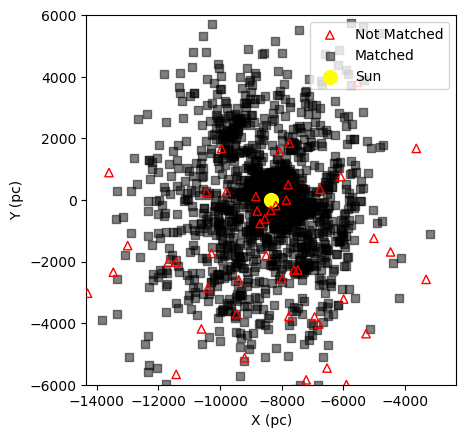

In [160]:
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
# get position of the sun from astropy

sun = SkyCoord(0,0,0, frame='galactic', representation_type='cartesian', unit='pc')
sun = sun.transform_to(coord.Galactocentric(galcen_distance=8.340*u.kpc))

not_matched_galcen = SkyCoord(cantat_not_matched['X'], cantat_not_matched['Y'], cantat_not_matched['Z'], unit='pc', representation_type='cartesian', frame='galactic').transform_to(coord.Galactocentric(galcen_distance=8.340*u.kpc))

plt.scatter(not_matched_galcen.x, not_matched_galcen.y, alpha=1, marker='^', color='red', facecolor='None', zorder=3, label='Not Matched')
plt.scatter(cantat_matched['X'], cantat_matched['Y'], alpha=0.5, marker='s', color='black', label='Matched')
plt.scatter(sun.x, sun.y, color='yellow', marker='o', s=100, label='Sun')

plt.scatter(0, 0, color='black', marker='x', s=100)
plt.annotate('GC', xy=(0, 0), xytext=(-500, 2000), arrowprops=dict(facecolor='black', arrowstyle='->', shrinkB = 5, connectionstyle = 'arc3, rad=-0.2'))

# center the plot
plt.xlim(sun.x.value-6000, sun.x.value+6000)
plt.ylim(sun.y.value - 6000, sun.y.value + 6000)
plt.gca().set_aspect('equal')

# add labels and legend
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.legend()

plt.show()

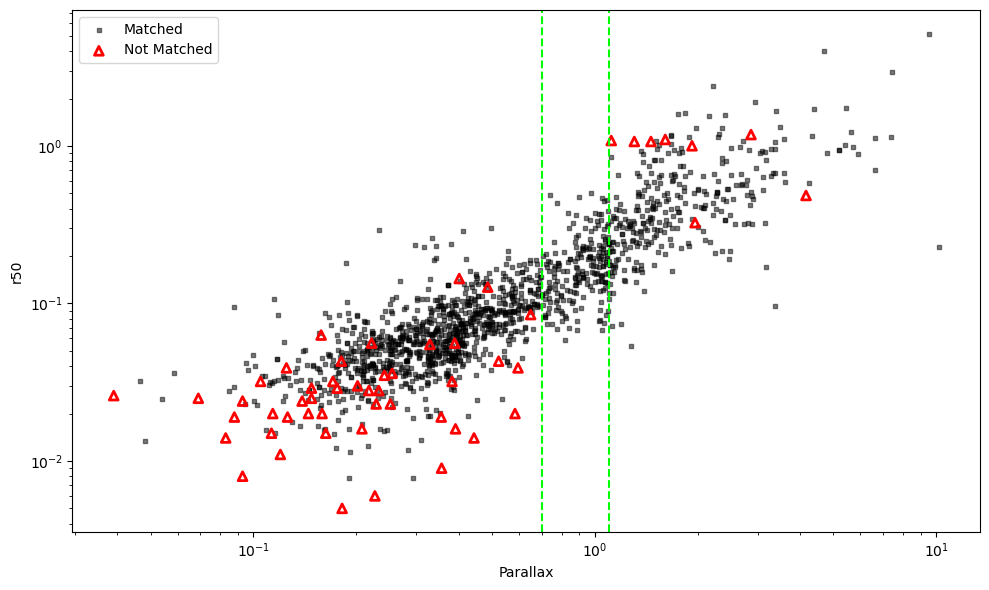

In [161]:
cantat_matched.columns
plt.figure(figsize=(10, 6))

plt.scatter(cantat_matched['Plx'], cantat_matched['r50'], marker='s', s=12, alpha=0.5, color='black', label='Matched')
plt.scatter(cantat_not_matched['Plx'], cantat_not_matched['r50'], marker='^', s=40, color='red', facecolor='None', linewidth=2, label='Not Matched')

plt.axvline(0.7, color='lime', linestyle='--')
plt.axvline(1.1, color='lime', linestyle='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Parallax')
plt.ylabel('r50')

plt.legend()
plt.tight_layout()
plt.show()


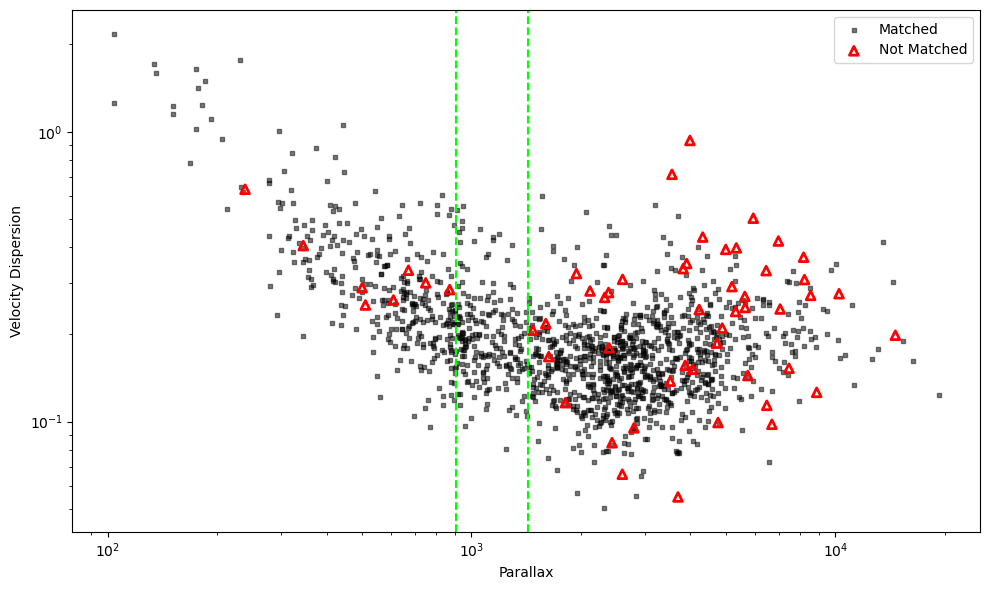

In [162]:
vel_disp = np.sqrt(cantat['s_pmDE']**2 + cantat['s_pmRA']**2)

def vel_disp(data):
    sig_dec, sig_ra = data['s_pmDE'], data['s_pmRA']
    return np.sqrt(sig_dec**2 + sig_ra**2)

# plot the velocity dispersion as a function of the parallax with the color representing the r50
plt.figure(figsize=(10, 6))

plt.scatter(cantat_lit['dmode'], vel_disp(cantat_lit), marker='s', color='black', s=12, alpha=0.5, label='Matched')
plt.scatter(cantat_not_matched['dmode'], vel_disp(cantat_not_matched), color='red', s=40, marker='^', facecolor='None', linewidth=2, label='Not Matched')

# make the same scatter but now with errorbars in the x and y direction
# plt.errorbar(cantat_lit['dmode'], vel_disp(cantat_lit), xerr=[cantat_lit['dmin'], cantat_lit['dmax']], yerr=[cantat_lit['s_pmDE'], cantat_lit['s_pmRA']], fmt='none', ecolor='black', alpha=0.5, zorder=1)
# plt.errorbar(cantat_not_matched['dmode'], vel_disp(cantat_not_matched), xerr=[cantat_not_matched['dmin'], cantat_not_matched['dmax']], yerr=[cantat_not_matched['s_pmDE'], cantat_not_matched['s_pmRA']], fmt='none', ecolor='red', alpha=0.5, zorder=1)



plt.axvline(parallax_to_dist(0.7), color='lime', linestyle='--')
plt.axvline(parallax_to_dist(1.1), color='lime', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance (pc)')
plt.ylabel('Velocity Dispersion (km/s)')
plt.tight_layout()
plt.legend()

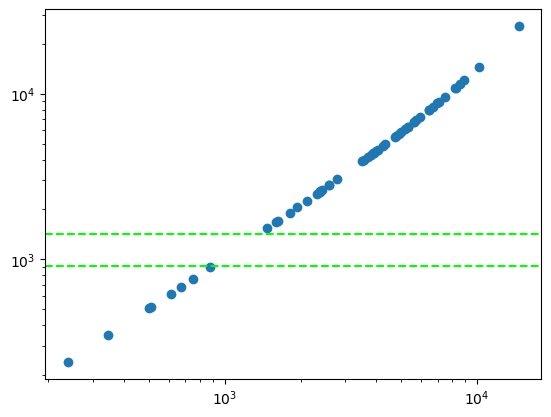

In [163]:
# create distance (x-axis) vs velocity dispersion (y-axis) plot


plt.scatter(cantat_not_matched['dmode'], parallax_to_dist(cantat_not_matched['Plx']))

plt.axhline(parallax_to_dist(0.7), color='lime', linestyle='--')
plt.axhline(parallax_to_dist(1.1), color='lime', linestyle='--')

plt.xscale('log')
plt.yscale('log')

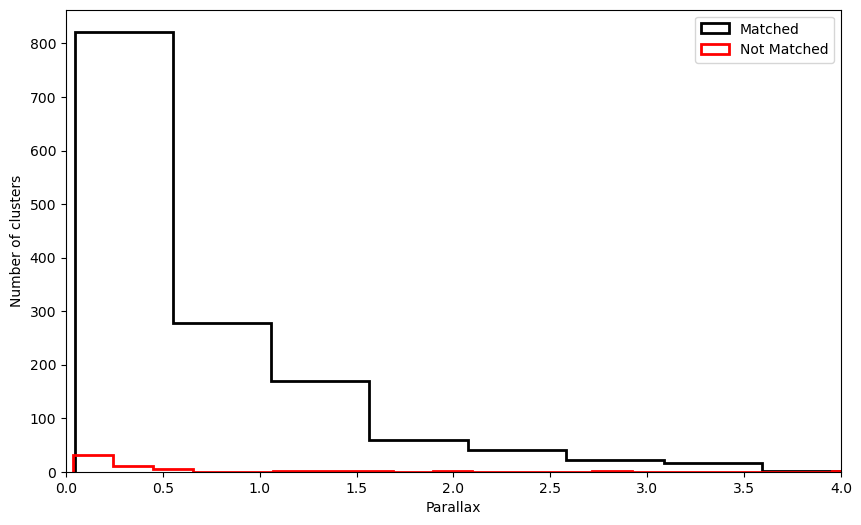

In [164]:
#create histogram of cantat's matched and not matched distribution of parallaxes, make the plot style step so we can see all histograms clearly. Assign nice colors
plt.figure(figsize=(10, 6))
plt.hist(cantat_matched['Plx'], bins=20, histtype='step', color='black', label='Matched', lw=2)
plt.hist(cantat_not_matched['Plx'], bins=20, histtype='step', color='red', label='Not Matched', lw=2)
plt.xlabel('Parallax')
plt.xlim(0,4)
plt.xlabel('Parallax')
plt.ylabel('Number of clusters')
plt.legend()

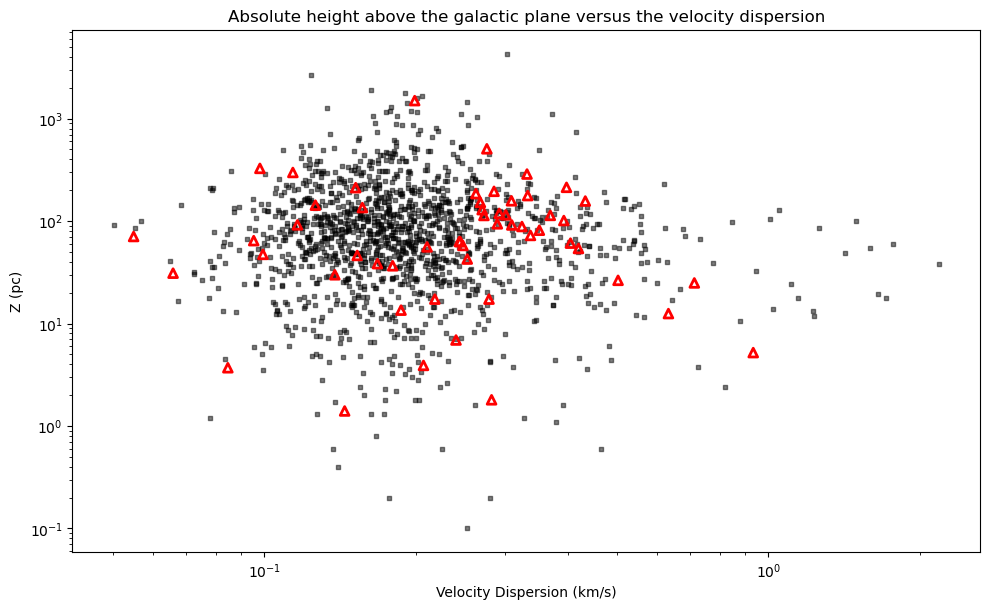

In [165]:
# plot the velocity dispersion versus the absolute height above the galactic plane
plt.figure(figsize=(10, 6))
plt.scatter(vel_disp(cantat_lit), np.absolute(cantat_lit['Z']), marker='s', color='black', s=12, alpha=0.5)
plt.scatter(vel_disp(cantat_not_matched), np.absolute(cantat_not_matched['Z']), color='red', s=40, marker='^', facecolor='None', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Z (pc)')
plt.xlabel('Velocity Dispersion (km/s)')
plt.tight_layout()

plt.title('Absolute height above the galactic plane versus the velocity dispersion')
plt.show()


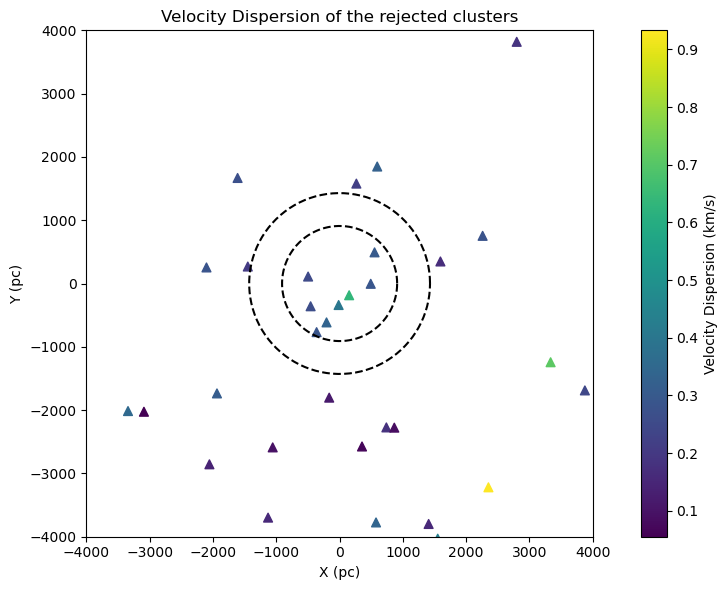

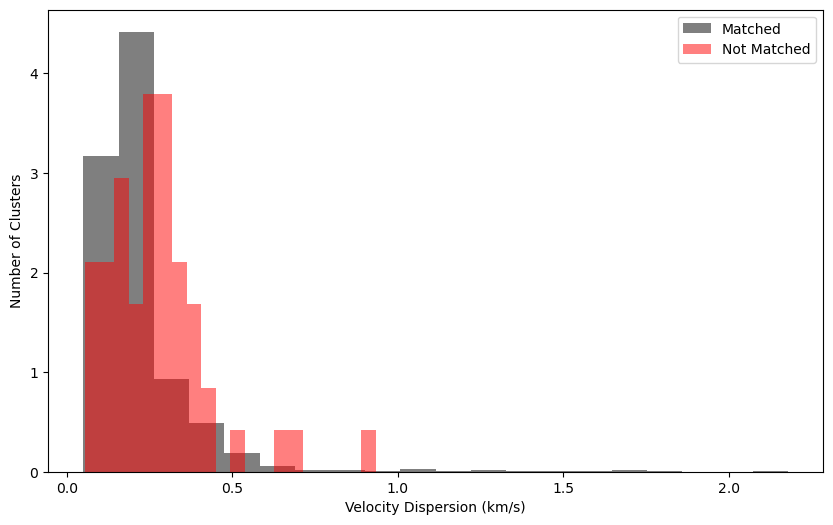

In [175]:
# make a plot of the x and y coordinates of the rejected clusters with color map representing the velocity dispersion

plt.figure(figsize=(10, 6))
plt.scatter(cantat_not_matched['X'], cantat_not_matched['Y'], c=vel_disp(cantat_not_matched), s=40, marker='^',cmap='viridis')
plt.colorbar(label='Velocity Dispersion (km/s)')

def plot_circle(x0 ,y0 ,r , color='black', linestyle ='--'):
    theta = np.linspace(0, 2*np.pi, 100)
    x = r*np.cos(theta) + x0
    y = r*np.sin(theta) + y0
    plt.plot(x, y, color=color, linestyle=linestyle)

plot_circle(0, 0, parallax_to_dist(0.7))
plot_circle(0, 0, parallax_to_dist(1.1))


plt.gca().set_aspect('equal')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.title('Velocity Dispersion of the rejected clusters')

plt.xlim(-4000, 4000)
plt.ylim(-4000, 4000)
plt.tight_layout()
plt.show()

# add a second plot in a subplot with a histogram of the velocity dispersion for the matched and rejected clusters
plt.figure(figsize=(10, 6))
plt.hist(vel_disp(cantat_lit), bins=20, color='black', alpha=0.5, label='Matched', density=True)
plt.hist(vel_disp(cantat_not_matched), bins=20, color='red', alpha=0.5, label='Not Matched', density=True)
plt.xlabel('Velocity Dispersion (km/s)')
plt.ylabel('Number of Clusters')
plt.legend()

(0.0, 17500.0)

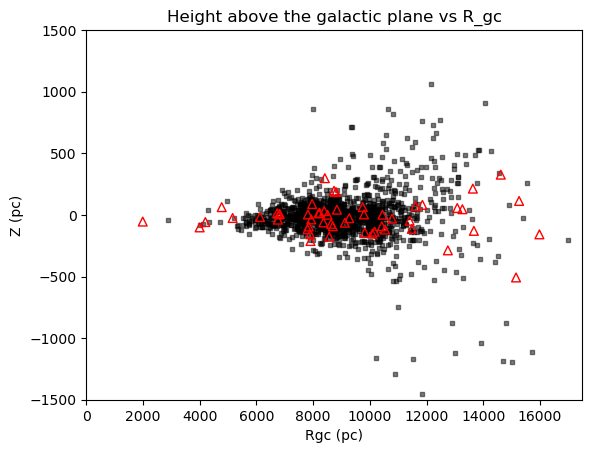

In [167]:
plt.scatter(cantat_lit['Rgc'], cantat_lit['Z'], marker='s', color='black', s=12, alpha=0.5)
plt.scatter(cantat_not_matched['Rgc'], cantat_not_matched['Z'], color='red', s=40, marker='^', facecolor='None')
plt.title('Height above the galactic plane vs R_gc')
plt.xlabel('Rgc (pc)')
plt.ylabel('Z (pc)')
plt.ylim(-1500, 1500)
plt.xlim(0, 17500)

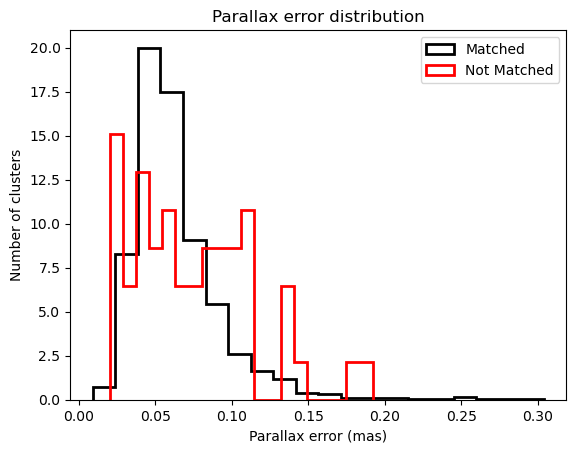

In [168]:
plt.hist(cantat_lit['s_Plx'], histtype='step', color='black', lw=2, bins=20, density=True, label='Matched'	)
plt.hist(cantat_not_matched['s_Plx'], histtype='step', color='red', lw=2, bins=20, density=True, label='Not Matched')
plt.xlabel('Parallax error (mas)')
plt.ylabel('Number of clusters')
plt.title('Parallax error distribution')
plt.legend()
plt.show()


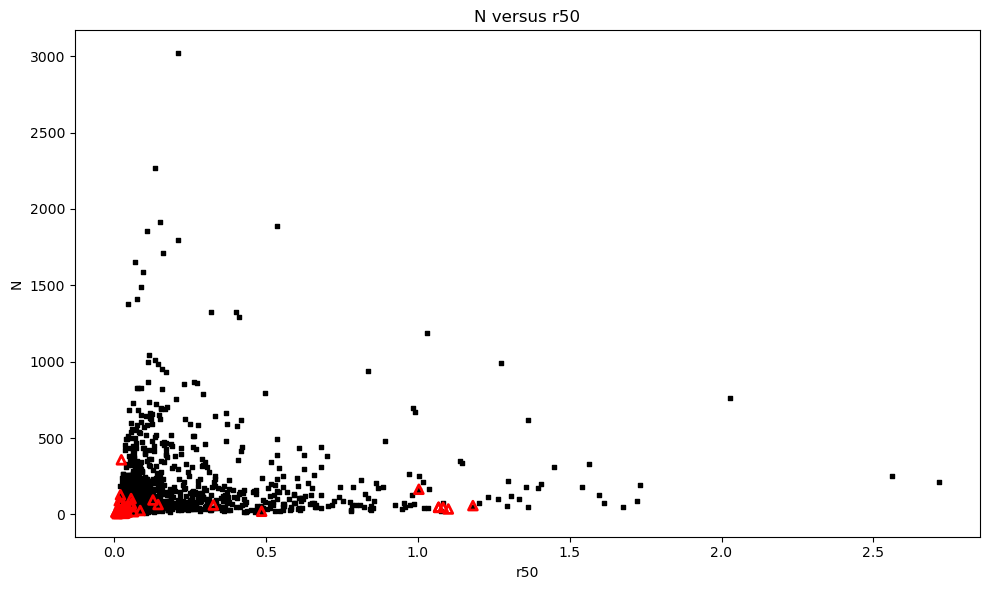

In [169]:
# plot the column N versus the column r50 with the color representing the velocity dispersion, do it for the matched and not matched clusters
plt.figure(figsize=(10, 6))
plt.scatter(cantat_lit['r50'], cantat_lit['N'], s=12, marker='s', color='black')
plt.scatter(cantat_not_matched['r50'], cantat_not_matched['N'], s=40, marker='^', edgecolor='red', facecolor='None', linewidth=2)

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('r50')
plt.ylabel('N')
plt.title('N versus r50')
plt.tight_layout()
plt.show()


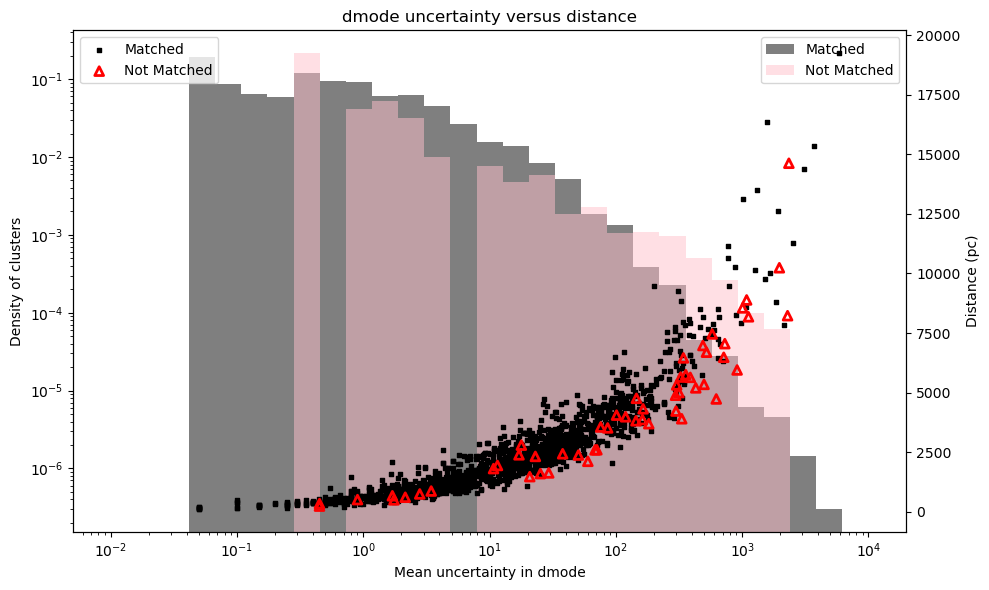

[ 3.6   0.55  0.75 ...  4.1  22.7   5.15]


In [170]:
# get the dmode columns
dmodes_not_matched = np.mean(np.diff(cantat_not_matched[['dmode16', 'dmode', 'dmode84']], axis=1), axis=1)
dmodes_lit = np.mean(np.diff(cantat_lit[['dmode16', 'dmode', 'dmode84']], axis=1), axis=1)


# plot the demode uncertainties versus the distance and use logarithmic scale
plt.figure(figsize=(10, 6))

plt.hist(dmodes_lit, bins=np.logspace(np.log10(0.01),np.log10(10000), 30), log=True, color='black', lw=2, alpha=0.5, density=True, label='Matched')
plt.hist(dmodes_not_matched, bins=np.logspace(np.log10(0.01),np.log10(10000), 30), log=True, color='pink', lw=2, alpha=0.5, density=True, label='Not Matched')

plt.xlabel('Mean uncertainty in dmode')
plt.xscale('log')
plt.ylabel('Density of clusters')
plt.legend()
# make the count of number of clusters on a second y-axis
plt.twinx()

plt.scatter(dmodes_lit, cantat_lit['dmode'], s=12, marker='s', color='black', label='Matched')
plt.scatter(dmodes_not_matched, cantat_not_matched['dmode'], s=40, marker='^', edgecolor='red', facecolor='None', linewidth=2, label='Not Matched')
plt.ylabel('Distance (pc)')

plt.title('dmode uncertainty versus distance')
plt.tight_layout()

# plot in the same figure a histogram density distribution of the dmode uncertainties for the matched and not matched clusters

plt.legend()
plt.tight_layout()
plt.show()


print(dmodes_lit)

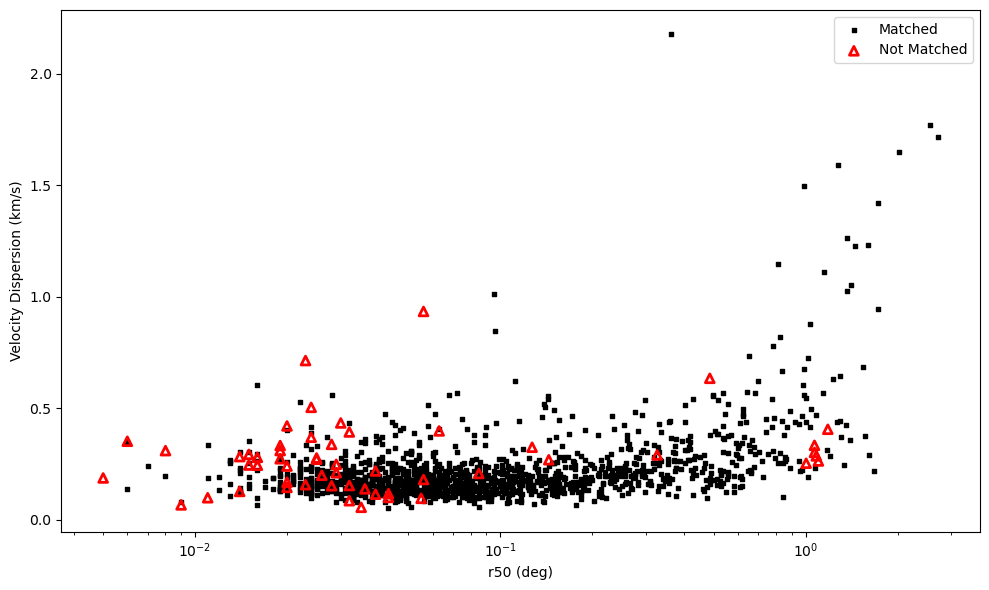

In [171]:
# make a plot of velocity dispersion vs r50 radius of the matched and not matched clusters
plt.figure(figsize=(10, 6))
plt.scatter(cantat_lit['r50'], vel_disp(cantat_lit), s=12, marker='s', color='black', label='Matched')
plt.scatter(cantat_not_matched['r50'], vel_disp(cantat_not_matched), s=40, marker='^', edgecolor='red', facecolor='None', linewidth=2, label='Not Matched')

plt.xscale('log')
# plt.yscale('log')

plt.xlabel('r50 (deg)')
plt.ylabel('Velocity Dispersion (km/s)')

plt.legend()
plt.tight_layout()
plt.show()



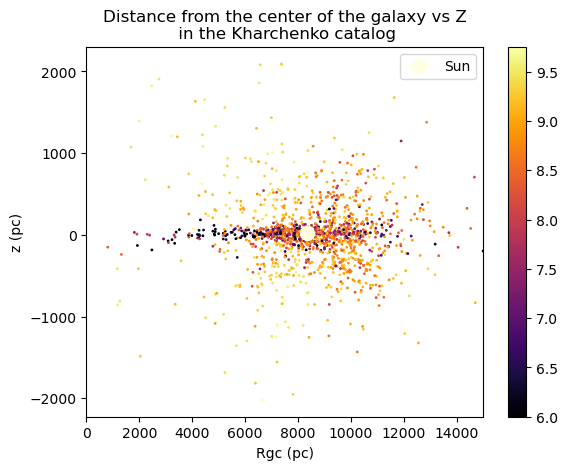

In [172]:
hunt_khar, khar_matched, khar_not_matched = datahandler(khar)

def radec_to_galcen(data):
    ra, dec, dist = data['RAhour'].values, data['DEdeg'].values, data['d'].values
    coords = coord.SkyCoord(ra=ra*u.hourangle, dec=dec*u.deg, distance=dist*u.pc, frame='icrs') # put into SkyCoord coordinates (is in icrs j2000)
    coords = coords.transform_to(coord.Galactocentric(galcen_distance=8340*u.pc)) # Convert to galactic coordinates assuming sun is at 8340 pc
    return coords.cartesian # return the cartesian coords instead b, l, d

# Function to calculate distance from the center of the galaxy in parsecs
def distance_from_center(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return r

x, y, z = radec_to_galcen(khar_not_matched).xyz.value
# # Calculate distance from the center of the galaxy in parsecs
r = distance_from_center(x, y, z)

#plot the sun
plt.plot(sun.galcen_distance.to(u.pc), sun.z_sun, color='lightyellow', marker='o', markersize=10, label='Sun')

plt.scatter(r, z, c = khar_not_matched['logt'], cmap = 'inferno', s=1)


plt.xlabel('Rgc (pc)')
plt.ylabel('z (pc)')
plt.title('Distance from the center of the galaxy vs Z\n in the Kharchenko catalog')
plt.xlim(0, 15000)

plt.colorbar()
plt.legend()
plt.show()

## Analyzing on the 1.1 mas inner circle
Here we look at the 1.1 mas inner circle which encloses the clusters COIN-Gaia_13, Platais_10, UBC_13, UBC_14, UBC_21, UPK_495, UPK_533, UPK_654.
We analyze various asterometric paramaters like dispersion.

In [173]:
innerclusters = cantat_not_matched.query('Plx > 1.1')
innerclusters



,Cluster,RAdeg,DEdeg,GLON,GLAT,r50,N,pmRA,s_pmRA,e_pmRA,...,dmode16,dmode,dmode84,dmode95,dmode+01,dmode-01,X,Y,Z,Rgc
226,COIN-Gaia_13,83.186,42.087,167.459,4.776,1.003,165.0,-3.828,0.185,0.017,...,510.4,511.3,512.2,512.9,486.4,538.8,-497.4,110.6,42.6,8838.0
1072,Platais_10,205.220,-59.271,309.220,2.996,0.485,21.0,-30.591,0.475,0.102,...,238.4,238.8,239.3,239.6,233.3,244.7,150.8,-184.8,12.5,8191.3
1309,UBC_13,120.914,3.540,218.116,17.666,1.100,36.0,-7.749,0.158,0.032,...,608.4,610.6,612.7,614.2,575.4,650.3,-457.7,-359.1,185.3,8805.0
1310,UBC_14,294.746,3.703,41.734,-8.829,1.068,46.0,0.131,0.210,0.024,...,746.2,749.0,751.8,753.6,696.8,809.6,552.3,492.7,-115.0,7803.3
1315,UBC_21,130.455,-20.747,244.679,12.944,1.083,47.0,-6.500,0.224,0.033,...,868.1,871.5,875.0,877.4,801.7,954.8,-363.3,-767.8,195.2,8737.1
1446,UPK_495,105.787,-40.885,251.411,-15.314,1.068,48.0,-2.489,0.160,0.023,...,669.6,671.4,673.0,674.1,629.1,719.7,-206.4,-613.7,-177.3,8568.4
1455,UPK_533,122.887,-52.521,267.426,-10.160,1.181,58.0,-6.876,0.299,0.043,...,344.7,345.1,345.6,345.9,333.6,357.5,-15.3,-339.4,-60.9,8362.1
1494,UPK_654,277.320,-34.528,359.531,-10.817,0.326,62.0,1.206,0.241,0.025,...,499.2,500.9,502.7,503.9,477.0,527.3,492.0,-4.0,-94.0,7848.0
